In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)
import itertools as it
from collections import Counter, defaultdict, deque
import json
import time
import itertools as it
import sys
from tqdm import tqdm
tqdm.pandas()
sys.path.append('lib')
from analysis_utils import *
from joblib import Parallel, delayed

# Load data

In [3]:
def load(v):
    """Loads data from experiment with codeversion `v`."""
    df = pd.read_csv('data/human/{}/mouselab-mdp.csv'.format(v))
    pdf = pd.read_csv('data/human/{}/participants.csv'.format(v))
    return df, pdf

def combine(*vs):
    """Load multiple versions at once."""
    def loop():
        first_pid = 0
        for v in vs:
            df = pd.read_csv('data/human/{}/mouselab-mdp.csv'.format(v))
            pdf = pd.read_csv('data/human/{}/participants.csv'.format(v))
            df.pid += first_pid
            pdf.pid += first_pid
            first_pid += max(pdf.pid.max(), df.pid.max()) + 1
            yield df, pdf
    dfs, pdfs = zip(*loop())
    df = pd.concat(dfs).reset_index()
    pdf = pd.concat(pdfs).reset_index().set_index('pid', drop=False)
    return df, pdf

VERSION = '1.7'
df, pdf = load(VERSION)

pr_types = 'none objectLevel featureBased'.split()
pdf['pr_type'] = pdf.PR_type.astype('category', categories=pr_types)
pdf.drop('PR_type', axis=1, inplace=True)
info_costs = list(pdf.info_cost.unique())

completed = list(pdf.query('completed').pid)
df = df.query('pid == @completed').copy()
pdf = pdf.query('pid == @completed').copy()

df.trial_index = df.trial_index.astype(int) - 1
df.trial_id = df.trial_id.astype(int)
df['version'] = list(pdf.version.loc[df.pid])
df['info_cost'] = list(pdf.info_cost.loc[df.pid])
df['pr_type'] = pd.Categorical(pdf.pr_type.loc[df.pid], categories=pr_types)
df['message'] = list(pdf.message.loc[df.pid])

from toolz.curried import *
from ast import literal_eval
df.queries = df.queries.apply(literal_eval)
df['clicks'] = df.queries.apply(
    lambda x: lmap(int, x['click']['state']['target'])
)
df['click_times'] = df.queries.apply(
    lambda x: x['click']['state']['time']
)
df.action_times = df.action_times.apply(literal_eval)
df['n_click'] = df.clicks.apply(len)
df.delays = df.delays.apply(literal_eval)
df.path = df.path.apply(
    lambda x: [1] + literal_eval(x)[1:])
df['feedback'] = df.planned_too_much.apply(literal_eval).apply(len)

pdf['time_elapsed'] = df.groupby('pid').time_elapsed.max() / 60000
pdf['score'] = df.groupby('pid').score.sum()
df.actions = df.actions.apply(literal_eval)

# df = df.query('info_cost == 1.25').copy()
# pdf = pdf.query('info_cost == 1.25').copy()
labeler = Labeler()
df['pidx'] = df.pid.apply(labeler)
pdf['pidx'] = pdf.pid.apply(labeler)
df = df.rename(columns={'p_rdata': 'pr_data'})
df.pr_data = df.pr_data.fillna('None').apply(literal_eval)



# Plot data

In [4]:
df['rank'] = df.groupby(['info_cost', 'trial_id']).score.rank(pct=True)

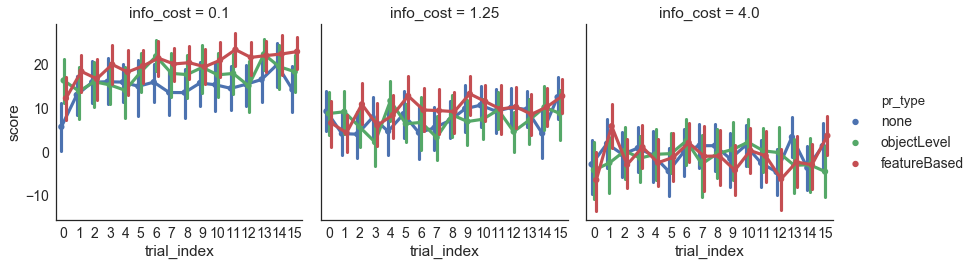

In [161]:
sns.factorplot('trial_index', 'score', hue='pr_type', col='info_cost',
               data=df, dodge=.3, estimator=np.mean, markers='.')

In [26]:
g = df.groupby(['info_cost', 'trial_id']).score
df['score_diff'] = g.apply(lambda x: x - x.mean())
df['score_z'] = g.apply(lambda x: (x - x.mean()) / x.std())

In [40]:
g = df.groupby(['info_cost', 'trial_id']).score
df['score_z'] = g.apply(lambda x: (x - x.mean()) / x.std())
first = df.groupby('pid').score_z.first()
df['score_z_diff'] = df.score_z - first[df.pid].as_matrix()

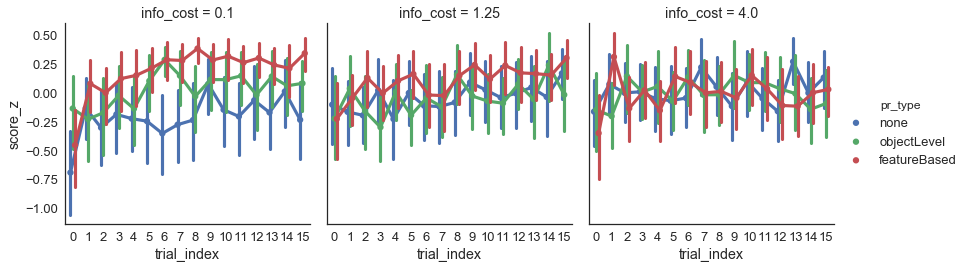

In [966]:
sns.factorplot('trial_index', 'score_z', hue='pr_type', col='info_cost',
               data=df, dodge=.3, estimator=np.mean, markers='.')

In [6]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

In [8]:
%%R
library(lme4)
library(car)

In [164]:
cols = 'rank info_cost score score_z score_z_diff score_diff trial_index pr_type pid trial_id'.split()
rdf = df[cols].query('info_cost == 1.25')

In [170]:
%%R -i rdf
m = lmer(score ~ pr_type * trial_index + (1|trial_id), data=rdf)
Anova(m)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                      Chisq Df Pr(>Chisq)    
pr_type             14.2266  2  0.0008142 ***
trial_index         15.3486  1  8.939e-05 ***
pr_type:trial_index  0.7755  2  0.6785989    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [49]:
%%R -i rdf
m = lm(score_z ~ pr_type * trial_index, data=rdf)
Anova(m)

Anova Table (Type II tests)

Response: score_z
                    Sum Sq  Df F value Pr(>F)
pr_type               1.86   2  0.9854 0.3741
trial_index                  0               
pr_type:trial_index          0               
Residuals           434.01 460               


In [20]:
%%R -i rdf
m = lmer(score_z ~ pr_type * trial_index + (1|pid), data=rdf)
Anova(m)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score_z
                      Chisq Df Pr(>Chisq)    
pr_type             11.3822  2   0.003376 ** 
trial_index         36.1396  1  1.837e-09 ***
pr_type:trial_index  1.7051  2   0.426326    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Compare to LC

## Meta Regret

In [410]:
sys.path.append('../mcrl/')
from model_utils import make_env, make_envs
from value_functions import LiederQ
from agents import Agent

In [411]:
def load_qs():
    with open('../mcrl/data/q_weights.json') as f:
        q_weights = json.load(f)
    Qs = {}
    for cost, theta in q_weights.items():
        Q = LiederQ(theta)
        agent = Agent()
        agent.register(make_env(float(cost)))
        agent.register(Q)
        Qs[cost] = Q
    return Qs
        
Qs = load_qs()

In [412]:
env = make_env(0)
def parse_state(state):
    return tuple(env.reward if x == '__' else float(x)
                 for x in state)
def parse_action(action):
    return env.term_action if action == '__TERM_ACTION__' else action

In [413]:
%%time
from joblib import Parallel, delayed
def trial_regret(i, row):
    beliefs = lmap(parse_state, literal_eval(row.beliefs))
    actions = row.clicks + [env.term_action]
    Q = Qs[f'{row.info_cost:.2f}']

    def regret(s, a):
        q = Q.predict(s)
        return q.max() - q[a]

    return sum(regret(s, a) for s, a in zip(beliefs, actions))

def parallel_apply(df, func):
    jobs = (delayed(func)(i, row) for i, row in df.iterrows())
    return Parallel(n_jobs=-2)(jobs)

df['regret'] = parallel_apply(df['beliefs info_cost clicks'.split()], trial_regret)
df['performance'] = -df.regret

CPU times: user 5.29 s, sys: 898 ms, total: 6.19 s
Wall time: 1min 8s


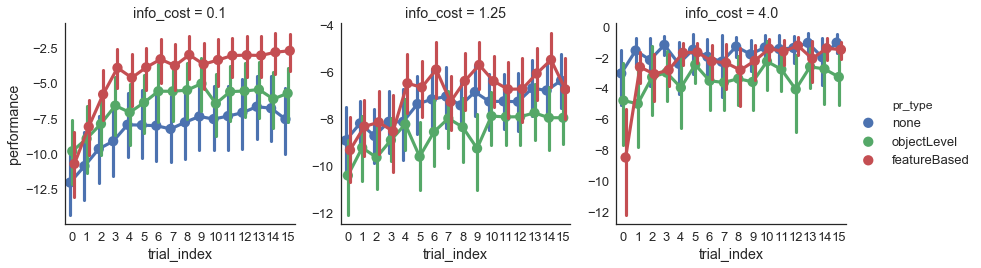

In [972]:
sns.factorplot('trial_index', 'performance', hue='pr_type', col='info_cost',
               data=df, dodge=.3, sharey=False)

In [968]:
g = df.groupby(['info_cost', 'trial_id']).regret
df['regret_z'] = g.apply(lambda x: (x - x.mean()) / x.std())
first = df.groupby('pid').regret_z.first()
df['regret_z_diff'] = df.regret_z - first[df.pid].as_matrix()

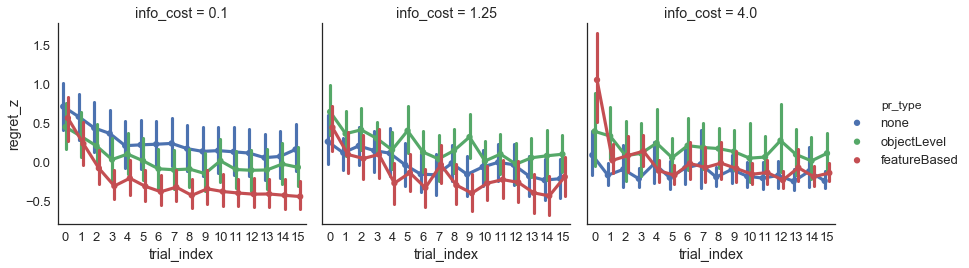

In [970]:
sns.factorplot('trial_index', 'regret_z', hue='pr_type', col='info_cost',
               data=df, dodge=.3, estimator=np.mean, markers='.')

## Relative score

In [415]:
cd ../mcrl

/home/fredcallaway/mcrl


In [416]:
from evaluation import evaluate
from model_utils import read_bo_policy, make_envs 
from policies import FixedPlanPolicy

term_action = 17

def test(cost):
    policies = {
        'BO': read_bo_policy(cost),
#         'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    envs = make_envs(cost, n=16, ground_truth=1, sample_term_reward=True)
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['agent'] = name
                df['trial_id'] = range(16)
                df['cost'] = cost
                yield df
    return pd.concat(loop())

jobs = (delayed(test)(c) for c in df.info_cost.unique())
mdf = pd.concat(Parallel(3)(jobs))

In [417]:
xdf = mdf.groupby('agent cost trial_id'.split())[['observations', 'util']].mean()
x = df.apply(lambda row: xdf.loc['BO', row.info_cost, row.trial_id], axis=1)
df['lc_score'] = x.util
df['relative_score'] = df.score - df.lc_score
df['lc_clicks'] = x.observations
df['relative_clicks'] = df.n_click - df.lc_clicks

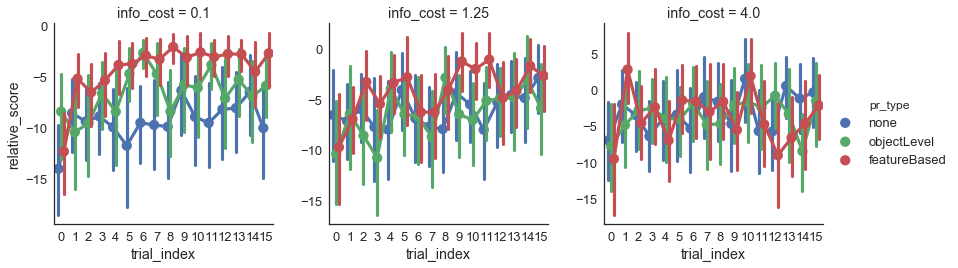

In [973]:
sns.factorplot('trial_index', 'relative_score', hue='pr_type', col='info_cost',
               data=df, dodge=.4, sharey=False)

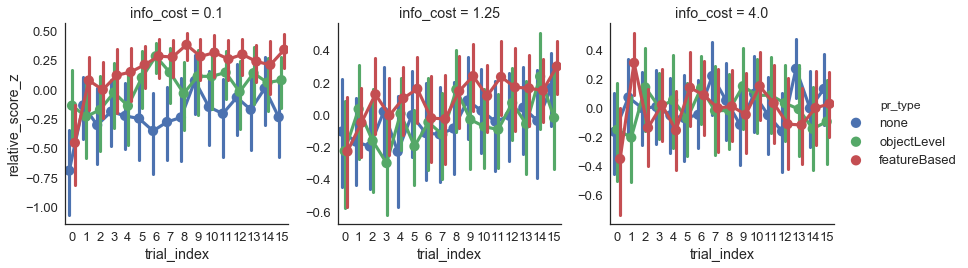

In [974]:
g = df.groupby(['info_cost', 'trial_id']).relative_score
df['relative_score_z'] = g.apply(lambda x: (x - x.mean()) / x.std())
sns.factorplot('trial_index', 'relative_score_z', hue='pr_type', col='info_cost',
               data=df, dodge=.4, sharey=False)

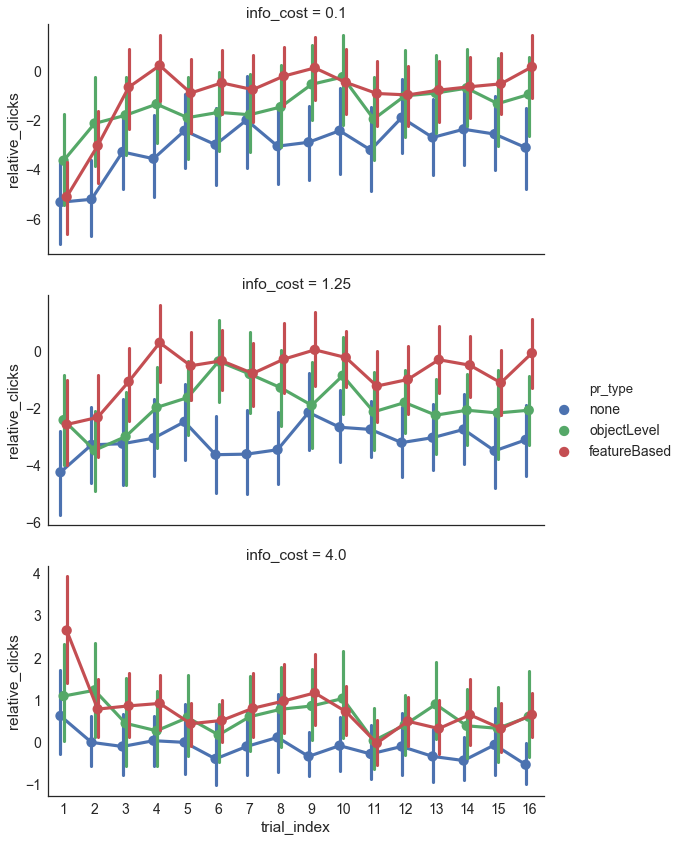

In [58]:
sns.factorplot('trial_index', 'relative_clicks', hue='pr_type', row='info_cost',
               data=df,
               aspect=2, dodge=.4, sharey=False)

# Bayesian data analysis

In [419]:
from pymc3 import *
import theano.tensor as tt
from theano.printing import Print

In [147]:
import warnings
warnings.simplefilter("ignore")
from collections import namedtuple
Result = namedtuple('Result', ['model', 'trace', 'MAP'])

def exponential_learning(t, low, high, rate, max_t):
    alpha = rate / (high - low)
    beta = (high - low) / (1 - tt.exp(-alpha * max_t))
    return low + beta * (1 - tt.exp(-alpha * t))

def model(df, ignore_pr=False):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    if ignore_pr:
        pr_type = np.zeros(len(df), dtype=int)
        n_pr = 1
    else:
        pr_type = df.pr_type.apply(pr_types.index).as_matrix()
        n_pr = len(pr_types)
    trial = df.trial_index.as_matrix()
    n_trial = trial.max() + 1
    cost = df.info_cost.apply(info_costs.index).as_matrix()
    n_cost = len(info_costs)
    
    with Model() as model:
        # Group level parameters.
        low = 0
        high = Exponential('high', 1, shape=(n_cost, n_pr))
        rate = Exponential('rate', 1, shape=(n_cost, n_pr))
        
        # Stimuli parameters.
        sigma = HalfCauchy('sigma', beta=10., shape=(n_cost, n_stim))
        baseline = Normal('baseline', 0, 100, shape=(n_cost, n_stim))
        
        # Generative model.
        t = np.arange(n_trial).reshape(-1, 1, 1)  # broadcasting
        skill = Deterministic('skill', exponential_learning(t, low, high, rate, n_trial-1))
        pred_score = Deterministic('pred_score', baseline[cost, stim] +
                                                 skill[trial, cost, pr_type] *
                                                 sigma[cost, stim])
        score = Normal('score', pred_score, sigma[cost, stim], 
                       observed=df.score.as_matrix())
        MAP = find_MAP()
        return Result(model, sample(500, njobs=22), MAP)

    
results = [model(df)]
# pmean = {k: trace[k].mean(0) for k in trace.varnames}

NameError: name 'Model' is not defined

In [749]:
import pymc3 as pm
tbl = pm.compare([r.trace for r in results], [r.model for r in results])
tbl

WAIC   pWAIC  dWAIC weight      SE   dSE warning
0  59643.7   145.7      0   0.94  173.76     0       1
1  59709.1  138.36  65.39   0.06  175.04  17.4       1

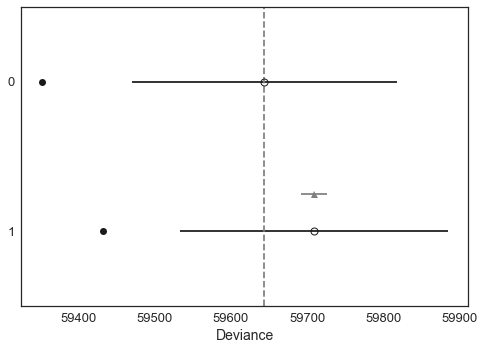

In [750]:
pm.compareplot(tbl)

In [598]:
[pm.dic(r.trace, r.model) for r in results]

[60311.413406433036, 60331.270738896026]

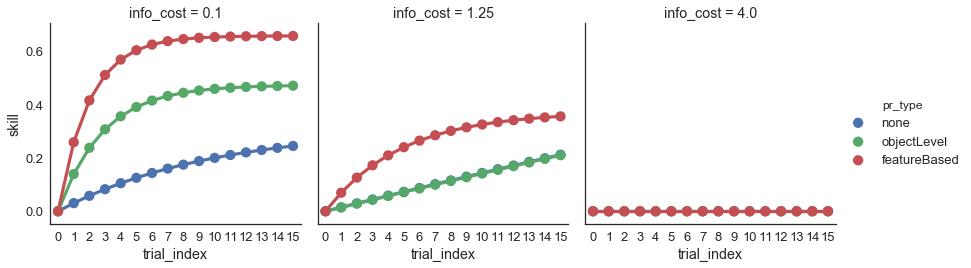

In [708]:
def plot_map_skill(MAP):
    idx = pd.MultiIndex.from_product([trials, info_costs, pr_types], 
                                     names=['trial_index', 'info_cost', 'pr_type'])
    df = pd.DataFrame({'skill': MAP['skill'].flatten()}, index=idx).reset_index()
    sns.factorplot('trial_index', 'skill', hue='pr_type', col='info_cost', data=df)

model, trace, MAP = results[0]
plot_map_skill(MAP)

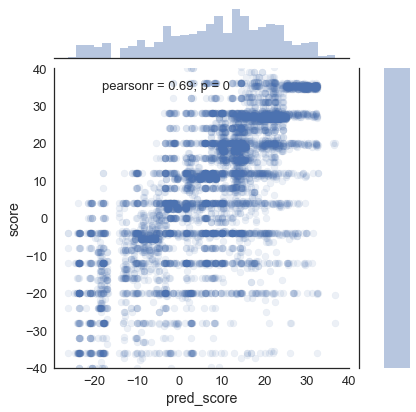

In [507]:
sns.jointplot('pred_score', 'score', data=df, joint_kws=dict(alpha=0.1))
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.gca().set_aspect('equal')

In [711]:
def var_df(var):
    panel = pd.Panel(trace[var], major_axis=info_costs, minor_axis=pr_types)
    frame = pd.melt(panel.to_frame().reset_index(),  id_vars=['major', 'minor'])
    frame = frame.rename(columns={'major': 'info_cost', 'minor': 'pr_type', 'variable': 'sample'})
    frame['var'] = var
    return frame

varnames = ['high', 'rate']
tdf = pd.concat(var_df(v) for v in varnames)

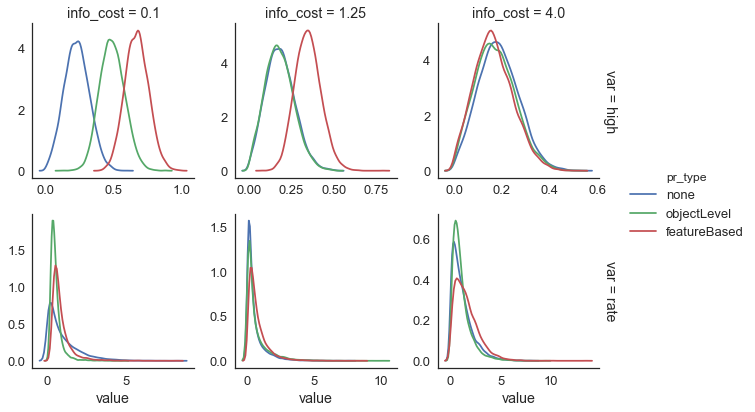

In [712]:
g = sns.FacetGrid(tdf, col='info_cost', row='var', hue='pr_type',
                  sharex=False, sharey=False, margin_titles=True)
g.map(sns.distplot, 'value', hist=False)
g.add_legend();

In [715]:
for var, vdf in tdf.groupby('var'):
    print(var)
    for cost, cdf in vdf.groupby('info_cost'):
        print(' ', cost)
        samples = cdf.set_index('pr_type').value
        def compare(a, b):
            prob = np.mean(samples[a].as_matrix() < samples[b].as_matrix())
            print(f'    P({a:12} < {b:12}) = {prob:.3f}')
        a,b,c = pr_types
        compare(a, b)
        compare(a, c)
        compare(b, c)

high
  0.1
    P(none         < objectLevel ) = 0.999
    P(none         < featureBased) = 1.000
    P(objectLevel  < featureBased) = 0.993
  1.25
    P(none         < objectLevel ) = 0.486
    P(none         < featureBased) = 0.976
    P(objectLevel  < featureBased) = 0.978
  4.0
    P(none         < objectLevel ) = 0.410
    P(none         < featureBased) = 0.365
    P(objectLevel  < featureBased) = 0.455
rate
  0.1
    P(none         < objectLevel ) = 0.415
    P(none         < featureBased) = 0.550
    P(objectLevel  < featureBased) = 0.739
  1.25
    P(none         < objectLevel ) = 0.523
    P(none         < featureBased) = 0.661
    P(objectLevel  < featureBased) = 0.621
  4.0
    P(none         < objectLevel ) = 0.485
    P(none         < featureBased) = 0.628
    P(objectLevel  < featureBased) = 0.651


In [731]:
samples = np.arange(len(trace['skill']))
idx = pd.MultiIndex.from_product([samples, trials, info_costs, pr_types],
                                 names=['sample', 'trial_index', 'info_cost', 'pr_type'])
sdf = pd.DataFrame({'skill': trace['skill'].flatten()}, index=idx).skill.reset_index()

In [735]:
sk = sdf.query('trial_index > 10').set_index(['pr_type', 'info_cost', 'trial_index', 'sample']).skill
d1 = (sk['featureBased'] > sk['none']).mean(level=[0])
d2 = (sk['featureBased'] > sk['objectLevel']).mean(level=[0])
print(pd.DataFrame({'meta > none': d1, 'meta > object': d2}))

           meta > none  meta > object
info_cost                            
0.10          1.000000       0.995945
1.25          0.987709       0.988291
4.00          0.368709       0.457200


In [752]:
sk = sdf.set_index(['pr_type', 'info_cost', 'trial_index', 'sample']).skill
(sk['featureBased'] > sk['none']).mean(level=[0,1])

info_cost  trial_index
0.10       0              0.000000
           1              0.989909
           2              1.000000
           3              1.000000
           4              1.000000
           5              1.000000
           6              1.000000
           7              1.000000
           8              1.000000
           9              1.000000
           10             1.000000
           11             1.000000
           12             1.000000
           13             1.000000
           14             1.000000
           15             1.000000
1.25       0              0.000000
           1              0.911182
           2              0.953182
           3              0.978182
           4              0.989455
           5              0.995273
           6              0.998182
           7              0.999000
           8              0.998909
           9              0.998636
           10             0.998091
           11             0.9962

In [885]:
sk = trace['skill'].mean(0)
skh = pm.hpd(trace['skill'])
sk.shape, skh.shape

((16, 3, 3), (16, 3, 3, 2))

In [886]:
lower = skh[:, :, :, 0]
mean = sk
upper = skh[:, :, :, 1]

idx = pd.MultiIndex.from_product([trials, info_costs, pr_types],
                                 names=['trial_index', 'info_cost', 'pr_type'])
lower = pd.Series(lower.ravel(), index=idx)
upper = pd.Series(upper.ravel(), index=idx)
est = pd.Series(mean.ravel(), index=idx)

In [887]:
hdf = pd.DataFrame({
    'lower': lower,
    'upper': upper,
    'est': est
}).reset_index()

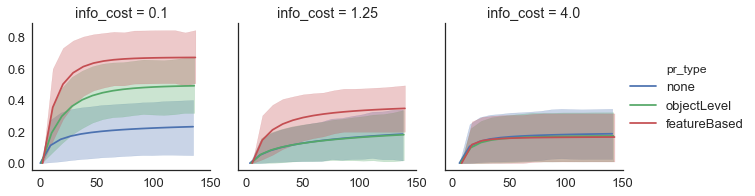

In [891]:
g = sns.FacetGrid(hdf, col='info_cost', hue='pr_type', aspect=1)

def plot(data, color, label):
#     offset = [0, 0.3, 0.6][pr_types.index(label)]
#     idx = data.index + offset
#     plt.errorbar(idx, data.est, [data.lower, data.upper], c=color, label=label,  elinewidth=1, linewidth=2)
    plt.plot(data.index, data.est, c=color, label=label)
    plt.fill_between(data.index, data.lower, data.upper, color=color, alpha=0.3)

g.map_dataframe(plot)
g.add_legend();

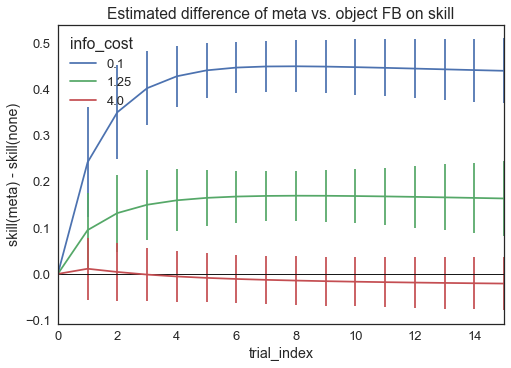

In [754]:
d1 = (sk['featureBased'] - sk['none']).groupby(level=[0, 1])
d1.mean().unstack().T.plot(yerr=d1.std().unstack().T)
plt.ylabel('skill(meta) - skill(none)')
plt.title('Estimated difference of meta vs. object FB on skill')
plt.axhline(0, c='k', lw=1)

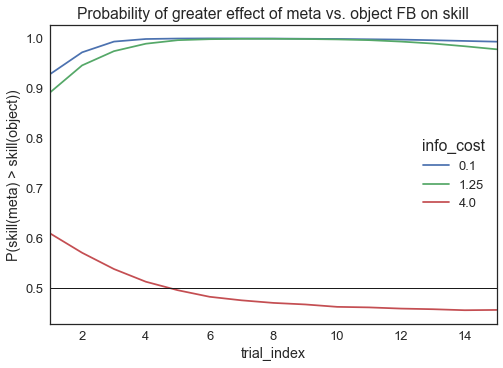

In [764]:
sk = sdf.query('trial_index > 0')

sk = sk.set_index(['pr_type', 'info_cost', 'trial_index', 'sample']).skill
d1 = (sk['featureBased'] > sk['objectLevel']).groupby(level=[0, 1])
d1.mean().unstack().T.plot()
plt.ylabel('P(skill(meta) > skill(object))')
plt.title('Probability of greater effect of meta vs. object FB on skill')
plt.axhline(0.5, c='k', lw=1)

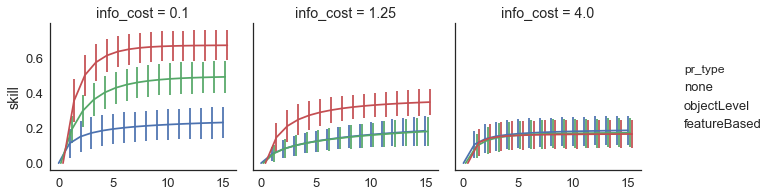

In [748]:
g = sns.FacetGrid(sdf, col='info_cost', hue='pr_type', aspect=1)

def plot(data, color, label):
    sk = data.groupby('trial_index').skill
    mean = sk.mean()
    std = sk.std()
    offset = [0, 0.2, 0.4][pr_types.index(label)]
    idx = mean.index + offset
    plt.errorbar(idx, mean, std, c=color)
#     mean.plot(yerr=std, label=label, c=color, )
#     plt.plot(idx, mean, c=color, label=label)
#     plt.fill_between(idx, mean-std, mean+std, color=color, alpha=0.2)
#     sk.mean().plot(yerr=sk.std(), c=color, label=label)

g.map_dataframe(plot)
g.add_legend();
g.axes.flat[0].set_ylabel('skill')

In [379]:
def sample_curves(thin=10):
    dd = df.copy()
    chains = trace.get_values('skill', combine=False)
    for ci, samples in enumerate(chains):
        for si in range(0, len(samples), thin):
            dd['skill'] = samples[si]
            skill = dd.groupby('pr_type trial_index'.split()).skill.mean().reset_index()
            skill['ci'] = ci
            skill['si'] = si
            yield skill

skill = pd.concat(sample_curves())

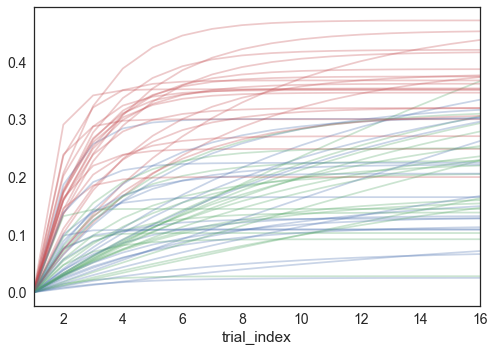

In [380]:
cmap = dict(zip(pr_types, sns.color_palette()))
for ci in skill.ci.unique():
    x = skill.query('ci == @ci and si == 490')
    for pr, dd in x.groupby('pr_type'):
        dd.set_index('trial_index').skill.plot(c=cmap[pr], alpha=0.3)

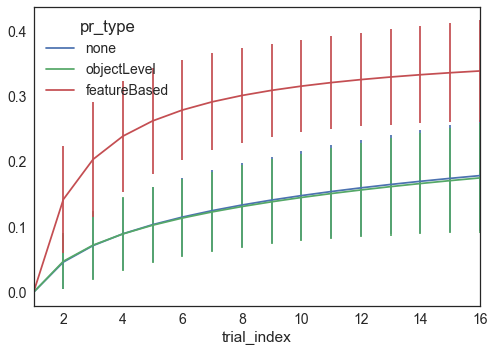

In [381]:
g = skill.groupby(['pr_type', 'trial_index'])

mean = g.skill.mean().unstack().T
std = g.skill.std().unstack().T
mean.plot(yerr=std)

# plot()


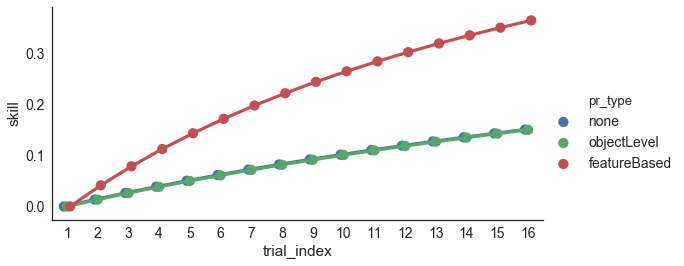

In [314]:
sns.factorplot('trial_index', 'skill', hue='pr_type', data=skill,
               aspect=2, dodge=.2)

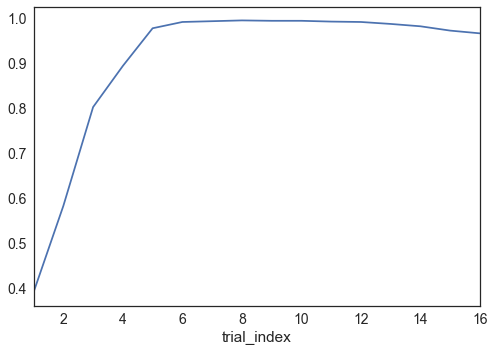

In [273]:
sk = skill.set_index(['pr_type', 'trial_index']).skill
((sk['none'] < sk['featureBased'])
 .reset_index()
 .groupby('trial_index')
 .skill
 .mean()
 .loc[3:]
 .mean()
 .plot()
)
# mean()


1.0428967216 -2.10456727025 -0.903627192269
0.815207965151 -2.57896872297 -0.960240049129
1.04782892702 5.35293502018 1.34158370506


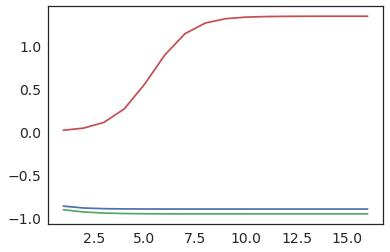

In [267]:
def logistic(x, k=1, x0=0, L=1):
    return L / (1 + np.exp(-k * (x - x0)))

t = df.trial_index.unique()
for pr, k, x0, L in zip(pr_types, *get('b_k b_x0 b_L'.split(), mle)):
#     if pr ==  'featureBased':
#         continue
    print(k, x0, L)
    plt.plot(t, logistic(t, k, x0, L))

# Exploratory

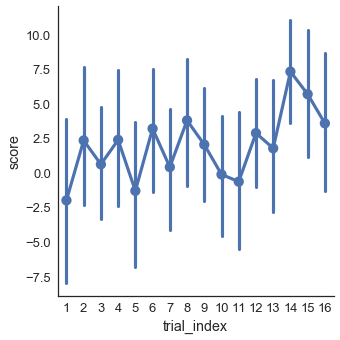

In [291]:
# sns.lmplot('trial_index', 'score', data=df, lowess=1, scatter_kws=dict(alpha=0))
# plt.ylim(-10, 10)
df.trial_index = df.trial_index.astype(int)
sns.factorplot('trial_index', 'score', data=df, size=5)


In [134]:
pdf.groupby(['message', 'PR_type']).apply(len)

message  PR_type     
full     featureBased    35
none     none            41
dtype: int64

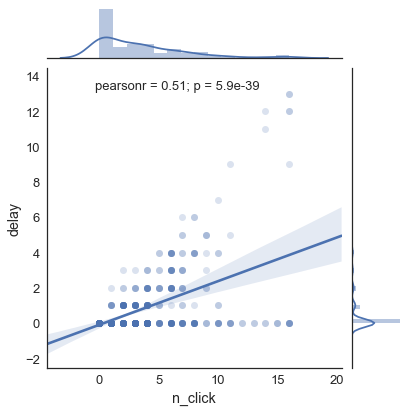

In [119]:
sns.jointplot('n_click', 'delay', data=df, kind='reg', scatter_kws=dict(alpha=0.2))

In [211]:
# df['over_plan'] = df.planned_too_much.apply(literal_eval).apply(sum)
# df['over_plan'] = df.planned_too_much.apply(literal_eval).apply(get(0, default=0)).apply(int)
df['over_plan'] = df.planned_too_much.apply(literal_eval).apply(sum)
df['under_plan'] = df.planned_too_little.apply(literal_eval).apply(get(0, default=0)).apply(int)
df['delay'] = df.delays.apply(get(0, default=0))
df['total_delay'] = df.delays.apply(sum)
# sns.factorplot('trial_index', 'over_plan', data=df)
# df.groupby('trial_index')[['over_plan', 'under_plan', 'delay']].mean().loc[:10].plot()

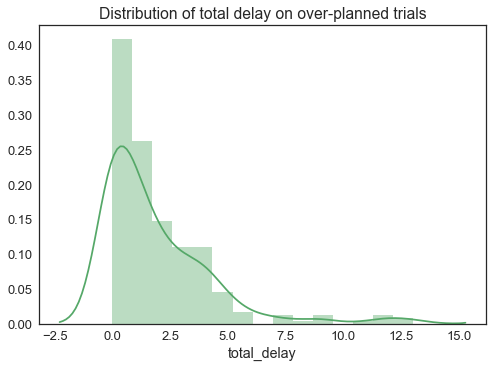

In [217]:
sns.distplot(df.query('over_plan > 0').total_delay, color='g')
plt.title('Distribution of total delay on over-planned trials')

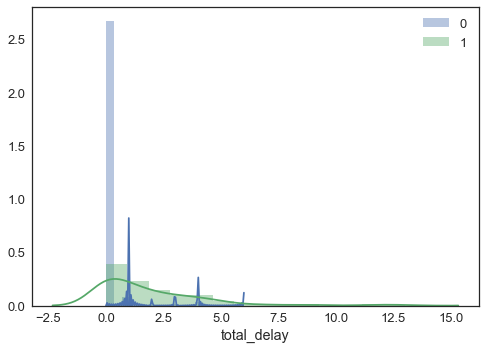

In [203]:
# sns.factorplot('over_plan', 'total_delay', data=df)
for op, dd in df.groupby('over_plan'):
    sns.distplot(dd.total_delay, label=str(op))
plt.legend()

In [101]:
sympy.init_printing()

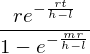

In [112]:
import sympy
t, low, high, rate, max_t = sympy.symbols('t l h r m')

def exponential_learning(t, low, high, rate, max_t):
    alpha = rate / (high - low)
    beta = (high - low) / (1 - sympy.exp(-alpha * max_t))
    return low + beta * (1 - sympy.exp(-alpha * t))

sympy.diff(exponential_learning(t, low, high, rate, max_t), t)

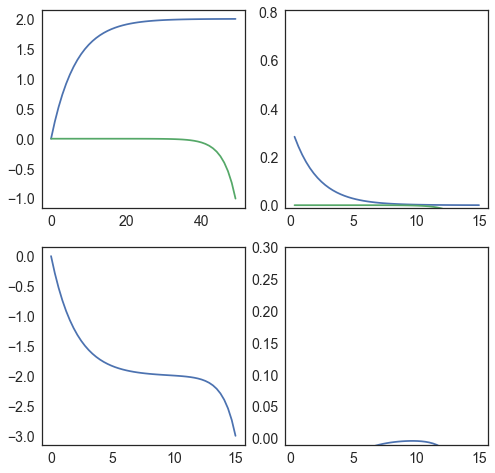

In [155]:
def exponential_learning(t, low, high, rate, max_t):
    alpha = rate
    alpha = rate / (high - low)
    beta = (high - low) / (1 - np.exp(-alpha * max_t))
    return low + beta * (1 - np.exp(-alpha * t))

x = np.linspace(0, 15)
ys = [
    exponential_learning(x, 0, 2, 1, 15),
    exponential_learning(x, 0, -1, 1, 15),
]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for y in ys:
    axes[0, 0].plot(y)
    axes[0, 1].plot(x[1:], np.diff(y))
axes[1, 0].plot(x, ys[1] - ys[0])
axes[1, 1].plot(x[1:], np.diff(ys[1]) - np.diff(ys[0]))
axes[1, 1].set_ylim(-.01, .3)
axes[0, 1].set_ylim(-.01, .81);

In [118]:
def exponential_rise(x, low, high, rate):
    return low + (high - low) * (1 - tt.exp(-rate * x))

def model(df):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    pr_type = df.pr_type.apply(pr_types.index).as_matrix()
    n_pr = 3
    trial = (df.trial_index - 1).as_matrix()
    n_trial = trial.max() + 1
    
    with Model() as model:
        # Group level parameters.
        low = Uniform('low', -1, 1)
        high = Uniform('high', low, 1, shape=n_pr)
#         low = low[pr_type]
        high = high[pr_type]
        rate = Exponential('rate', n_trial, shape=n_pr)[pr_type]
        
        std_stim = HalfCauchy('std_stim', beta=10., shape=n_stim)[stim]
        
#         pr_effect = Normal('pr_effect', 0, 10, shape=(n_pr, n_trial))[pr_type, trial]
#         pred_score = Deterministic('pred_score', L_stim + pr_effect)
        
        # Generative model.
        skill = Deterministic('skill', exponential_rise(trial, low, high, rate))
#         improvement = logistic(trial, x0, k, L - baseline_pid)
#         skill = Deterministic('skill', baseline_pid + improvement)
        pred_score = Deterministic('pred_score', skill * df.lc_score.as_matrix())
        score = Normal('score', pred_score, std_stim, 
                       observed=df.score.as_matrix())
    
        return sample(500, njobs=22)
    
df = full_df.query('info_cost == 1.25').copy()
trace = model(df)
mle = {k: trace[k].mean(0) for k in trace.varnames}

low
  P(none         < objectLevel ) = 0.224
  P(none         < featureBased) = 0.699
  P(objectLevel  < featureBased) = 0.863
high
  P(none         < objectLevel ) = 0.484
  P(none         < featureBased) = 0.719
  P(objectLevel  < featureBased) = 0.732
rate
  P(none         < objectLevel ) = 0.630
  P(none         < featureBased) = 0.737
  P(objectLevel  < featureBased) = 0.638


In [691]:
import warnings
warnings.simplefilter("ignore")
from collections import namedtuple
Result = namedtuple('Result', ['model', 'trace', 'MAP'])

def exponential_learning(t, low, high, rate, max_t):
    beta = (high - low) / (1 - tt.exp(-rate * max_t))
    return low + beta * (1 - tt.exp(-rate * t))

def model(df, ignore_pr=False):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    if ignore_pr:
        pr_type = np.zeros(len(df), dtype=int)
        n_pr = 1
    else:
        pr_type = df.pr_type.apply(pr_types.index).as_matrix()
        n_pr = len(pr_types)
    trial = df.trial_index.as_matrix()
    n_trial = trial.max() + 1
    cost = df.info_cost.apply(info_costs.index).as_matrix()
    n_cost = len(info_costs)
    
    with Model() as model:
        # Group level parameters.
        low = HalfNormal('low', sd=10, shape=(n_cost, n_pr))
        improvement = Uniform('improvement', 0, low, shape=(n_cost, n_pr))
        high = Deterministic('high', low - improvement)
        rate = Exponential('rate', 1, shape=(n_cost, n_pr))
        
        # Stimuli parameters.
        sigma = HalfCauchy('sigma', beta=10., shape=(n_cost, n_stim))
        baseline = Normal('baseline', 0, 10, shape=(n_cost, n_stim))
        
        # Generative model.
        t = np.arange(n_trial).reshape(-1, 1, 1)  # broadcasting
        skill = Deterministic('skill', exponential_learning(t, low, high, rate, n_trial-1))
        pred_regret = Deterministic('pred_regret', baseline[cost, stim] +
                                                   skill[trial, cost, pr_type] *
                                                   sigma[cost, stim])
        regret = Normal('regret', pred_regret, sigma[cost, stim], 
                       observed=df.regret.as_matrix())
        MAP = find_MAP()
        return Result(model, sample(500, njobs=22), MAP)


results = [model(df)]
# pmean = {k: trace[k].mean(0) for k in trace.varnames}

logp = nan, ||grad|| = 57.566: 100%|██████████| 278/278 [00:00<00:00, 496.37it/s] 
100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s]


In [257]:
def logistic(x, k=1, x0=0, L=1):
    return L / (1 + tt.exp(-k * (x - x0)))

def model(df):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    pr_type = df.pr_type.apply(pr_types.index).as_matrix()
    n_pr = 3
    trial = (df.trial_index).as_matrix()
    n_trial = trial.max() + 1
    
    with Model() as model:
        # Group level parameters.
        L = Normal('L', 0, 10, shape=n_pr)[pr_type]
        x0 = Normal('x0', 0, 10, shape=n_pr)[pr_type]
        k = Exponential('k', 1, shape=n_pr)[pr_type]

        # Participant level parameters.
#         baseline_pid = Normal('baseline_pid', 0, 10, shape=n_pid)[pid]
        baseline_pid = 0

        # Stimulus parameters.
        L_stim = Normal('L_stim', df.score.mean(), 100, shape=n_stim)[stim]
        std_stim = HalfCauchy('std_stim', beta=10., shape=n_stim)[stim]
        
#         pr_effect = Normal('pr_effect', 0, 10, shape=(n_pr, n_trial))[pr_type, trial]
#         pred_score = Deterministic('pred_score', L_stim + pr_effect)
        
        # Generative model.
        improvement = logistic(trial, x0, k, L - baseline_pid)
        skill = Deterministic('skill', baseline_pid + improvement)
        pred_score = Deterministic('pred_score', L_stim + std_stim * skill)
        score = Normal('score', pred_score, std_stim, 
                       observed=df.performance.as_matrix())
    
        return sample(500, njobs=23)
    
trace = model(df.query('info_cost == 1.25').copy())
mle = {k: trace[k].mean(0) for k in trace.varnames}

 32%|███▏      | 321/1000 [01:52<03:57,  2.86it/s]/home/fredcallaway/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.535474282606, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 73 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 40%|███▉      | 395/1000 [02:32<03:52,  2.60it/s]/home/fredcallaway/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 9 does not match the target. It is 0.933882794169, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 45%|██

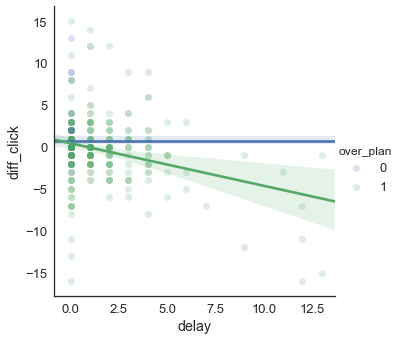

In [184]:
df['next_score'] = [0] + list(df.score[:-1])
df['next_click'] = [0] + list(df.n_click[:-1])
df['diff_click'] = df.next_click - df.n_click
sns.lmplot('delay', 'diff_click', hue='over_plan', 
           data=df.query('trial_index < 11 and PR_type == "featureBased"'),
           scatter_kws=dict(alpha=0.2), )

# Generate files

In [14]:
cols = ('pid info_cost PR_type message trial_index trial_i delays '
        'score n_click clicks click_times path action_times'
        .split())
df[cols].to_csv('data/human/{}/trials.csv'.format(VERSION))

In [271]:
identifiers = pd.read_csv('data/human_raw/{}/identifiers.csv'.format(VERSION))
pdf = pd.read_csv('data/human/{}/participants.csv'.format(VERSION))
pdf = pdf.join(identifiers.set_index('pid'))
pdf.bonus
# xx = pdf.set_index('worker_id')[['score', 'return_time', 'test_idx']]
# xx['test_idx'] = [[0,1,2,3,4,5]]
# xx.to_json('exp1/static/json/stage1.json',orient='index')

# (pd.read_csv('data/human/{}/survey-text.csv'.format(VERSION))
#  .responses.apply(literal_eval).apply(get('Q0')))

0    3.33
1    1.73
Name: bonus, dtype: float64

In [35]:
from toolz import *

df['info_cost'] = list(pdf.info_cost[df.pid])
def write_state_actions():
    for cost, dd in df.groupby('info_cost'):
        data = {}
        data['states'] = list(concat(dd.beliefs))
        data['actions'] = list(concat(dd.meta_actions))
        with open(f'../python/data/state_actions_{cost:.2f}.json', 'w+') as f:
            json.dump(data, f)
        
write_state_actions()
    

FileNotFoundError: [Errno 2] No such file or directory: '../python/data/state_actions_0.10.json'

In [71]:
DEBUG = []
def parse_row(row):
    times = row.action_times + row.click_times
    acts = row.actions + row.clicks
    try:
        sorted_acts = np.array(acts)[np.argsort(times)]
    except:
        DEBUG.append(row)
        return None
    for a in sorted_acts:
        try:
            state = int(a)
        except:
            state = None
        yield {'is_click': state is not None,
               'move': a if state is None else None,
               'state': state}
        
from analysis_utils import *

for pid, dd in df.groupby('pid'):
    cond = pdf.condition[pid]
    dd = dd.sort_values('trial_i')
    # trace = list(filter(None, rowapply(dd, compose(list, parse_row))))
    trace = list(rowapply(dd, compose(list, parse_row)))
    path = 'data/human/{}/traces/{}/'.format(VERSION, cond)
    os.makedirs(path, exist_ok=True)
    with open(path + '{}.json'.format(pid), 'w+') as f:
        json.dump(trace, f)

In [72]:
df = df.drop(df[df.click_times.apply(lambda x: None in x)].index)
def click_then_move(row):
    return max(row.click_times, default=-1) < min(row.action_times)

np.mean(rowapply(df, click_then_move))

0.75949754901960786

In [14]:
VERSION = '1A.1'
errors = []
sys.path.append('bin')
from compensation import Compensator
comp = Compensator()
identifiers = pd.read_csv('data/human_raw/{}/identifiers.csv'.format(VERSION))
pdf = pd.read_csv('data/human/{}/participants.csv'.format(VERSION))
pdf = pdf.join(identifiers.set_index('pid'))

True

In [180]:
for i, row in pdf.iterrows():
    # comp.approve(row.assignment_id)
    if row.bonus > 0:
        result = comp.grant_bonus(row.worker_id, row.assignment_id, round(row.bonus, 2))
        if result:
            errors.append(result)

Compensator: Skipping previously bonused worker A10ZKWRZ8WL775
Compensator: Skipping previously bonused worker A112V6HAH568DI
Compensator: Skipping previously bonused worker A11ASDVMEEIYZE
Compensator: Skipping previously bonused worker A11WXSQQRJGQDR
Compensator: Skipping previously bonused worker A12WRJ2ZMDW3SU
Compensator: Skipping previously bonused worker A136WVBAZDIVLZ
Compensator: Skipping previously bonused worker A16AFSPBIJC9CA
Compensator: Skipping previously bonused worker A17KSIKT9ZPR75
Compensator: Skipping previously bonused worker A17M78CCTQFUAO
Compensator: Skipping previously bonused worker A17UTAVQMEF94Z
Compensator: Skipping previously bonused worker A18FVXL05I2YEO
Compensator: Skipping previously bonused worker A19RNVJ2IO0HCS
Compensator: Skipping previously bonused worker A1ADGLKC2F1CHS
Compensator: Skipping previously bonused worker A1AXJTLZGJ42MV
Compensator: Skipping previously bonused worker A1B0D5F4TC9FMI
Compensator: Skipping previously bonused worker A1BABC5

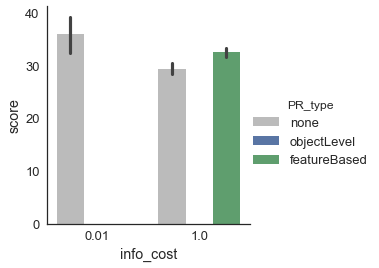

In [76]:
PALETTE = ['#bbbbbb'] + sns.palettes.SEABORN_PALETTES['deep']
sns.set_palette(PALETTE)
PR_ORDER = 'none objectLevel featureBased'.split()
# PR_ORDER = ['objectLevel', 'featureBased']

sns.factorplot('info_cost', 'score', hue='PR_type', data=df, 
               kind='bar', hue_order=PR_ORDER)

In [80]:
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return comp
    return comp.stack()
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

c = comparison('optimal')

In [78]:
INFO_COSTS = [0.01, 1.00, 2.50]
# INFO_COSTS = pdf.info_cost.unique()
dd = df.copy()
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return list(comp[1.0].loc[df.trial_i])
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

df['optimal'] = comparison('optimal')
df['worst'] = comparison('worst')

# df['optimal'] = list(optimal.loc[df.trial_i])
df['regret'] = df.score - df.optimal
df['trial_mean'] = list(df.groupby('trial_i').score.mean().loc[df.trial_i])
df['centered_score'] = df.score - df.trial_mean

# (R-R_min)/(R_max-R_min)
df['relative_score'] = (df.score - df.worst) / (df.optimal - df.worst)

In [88]:
def hamming_distance(s1, s2):
    assert(len(s1) == len(s2))
    dif = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            dif += 1

    return dif

def foobar(s1, s2):
    return sum(1 for c1, c2 in zip(s1, s2)
               if c1 != c2)

In [103]:
df['condition'] = pdf.PR_type.apply(lambda x: 'constant' if x == 'none' else 'pseudo') + '_' + pdf.message

In [278]:

sns.lmplot('trial_index', 'score', hue='message', col='PR_type', data=df,
           size=4, sharey=True, lowess=True, scatter=0)

KeyError: "['PR_type' 'message'] not in index"

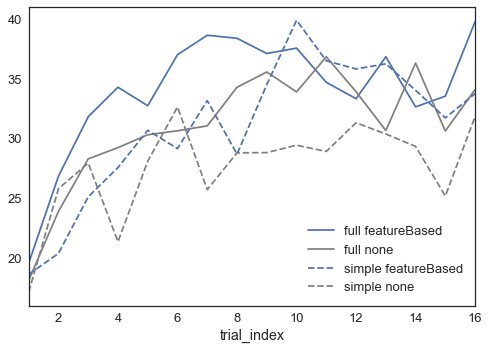

In [101]:
# dd = df.set_index('trial_index')
def plot():
    ax = plt.gca()
    pr_c = {'none': 'gray', 'featureBased': 'b'}
    msg_ls = {'simple': '--', 'full': '-'}
    dd = df.groupby(['message', 'PR_type', 'trial_index']).score.mean()
    for (m, p), dd in df.groupby(['message', 'PR_type']):
        try:
            dd.groupby('trial_index').score.mean().plot(
                ax=ax, c=pr_c[p], ls=msg_ls[m], label='{} {}'.format(m, p))
        except:
            pass
    plt.legend()
plot()


In [89]:
sns.lmplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False, lowess=True, scatter=0,
               hue_order=PR_ORDER, palette=PALETTE)

NameError: name 'PR_ORDER' is not defined

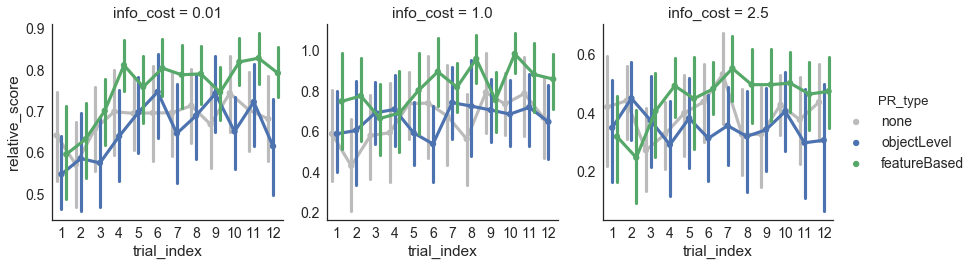

In [27]:
sns.factorplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False,
               dodge=.5, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

In [11]:
cols = [
    'info_cost',
    'relative_score',
    'trial_index',
    'score',
    'n_click',
    'pid',
    'trial_i',
    'PR_type',
    'test',
    'message'
]
rdf = df2r(df, cols)

KeyError: "['relative_score'] not in index"

In [178]:
%%R -i rdf
require(lme4)
require(car)
require(lsmeans)
# rdf$info_cost = as.factor(rdf$info_cost)
m = Anova(lmer('score ~ trial_index * PR_type * message + (1|pid) + (1|trial_i)', 
          data=rdf,
           # data=subset(rdf, info_cost == .01)
                      ))
m

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                              Chisq Df Pr(>Chisq)    
trial_index                 39.4779  1  3.318e-10 ***
PR_type                      4.5890  1   0.032178 *  
message                      9.5945  1   0.001952 ** 
trial_index:PR_type          1.3766  1   0.240677    
trial_index:message          0.0483  1   0.826118    
PR_type:message              1.7674  1   0.183701    
trial_index:PR_type:message  0.0122  1   0.911898    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [10]:
%%R -i rdf
Anova(lm
      ('score ~ condition', 
           data=subset(rdf, trial_index == 1)
                      ))

NameError: name 'rdf' is not defined

In [222]:
pdf.groupby('condition')[['PR_type', 'message']].apply(lambda x: x.iloc[0])

PR_type message
condition                      
0                  none    full
1                  none  simple
2          featureBased    full
3          featureBased  simple

In [217]:
%%R -i rdf
Anova(lm
      ('score ~ message * PR_type', 
           data=subset(rdf, trial_index == 1)
                      ))

Anova Table (Type II tests)

Response: score
                Sum Sq  Df F value  Pr(>F)  
message             35   1  0.0936 0.75997  
PR_type           1015   1  2.7350 0.09983 .
message:PR_type    344   1  0.9259 0.33715  
Residuals        70133 189                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [206]:
df.query('trial_index == 1').groupby('condition').n_click.mean()

condition
constant_full      3.80
constant_simple    7.75
pseudo_full        4.50
pseudo_simple      3.00
Name: n_click, dtype: float64

In [198]:
%%R
print('no feedback')
m = Anova(lmer('score ~ PR_type * message + (1|pid) + (1|trial_i)', 
#           data=rdf,
           data=subset(rdf, test==1)
                      ))
print(m)
print('feedback')
m = Anova(lmer('score ~ PR_type * message + (1|pid) + (1|trial_i)', 
#           data=rdf,
           data=subset(rdf, test==0)
                      ))
print(m)

[1] "no feedback"
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                 Chisq Df Pr(>Chisq)  
PR_type         1.2818  1    0.25757  
message         6.4725  1    0.01096 *
PR_type:message 2.0792  1    0.14932  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "feedback"
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                 Chisq Df Pr(>Chisq)   
PR_type         6.1773  1   0.012940 * 
message         7.9385  1   0.004839 **
PR_type:message 0.8277  1   0.362949   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [382]:
# from pymc3 import *

# with Model():
#     glm.GLM.from_formula('score ~ PR_type * trial_index', data=df)
#     start = find_MAP()
#     step = NUTS(scaling=start)
#     trace = sample(2000, step)
    

# full = t['PR_type[T.fullObservation]']
# none = t['PR_type[T.none]']
# (none > 0).mean()

Optimization terminated successfully.
         Current function value: 2314.381831

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  4%|▍         | 82/2000 [00:00<00:11, 173.13it/s]


         Iterations: 47
         Function evaluations: 55
         Gradient evaluations: 55
